In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import iirnotch, filtfilt, welch
import mne
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from plotting import plot_mvmd_grid, plot_mode_psds_multi_channel_modes_first,mvmd_plot_correlation_matrix_enveloppe,mvmd_plot_correlation_matrix_enveloppe_reordered,mvmd_plot_correlation_matrix_enveloppe_reordered, mvmd_plot_mean_mode_psds
from extract_envelopes import extract_mvmd_envelopes
from mfa_utils import mfa_on_envelope_centroids



## 1. Signal extraction

In [3]:
raw = mne.io.read_raw_fif("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif", preload=True)
raw = raw.copy().pick('meg')
data = raw.get_data()  # shape: (n_channels, n_times)
sfreq = raw.info["sfreq"]
print("sfreq",sfreq)
print("Shape:", data.shape)  # Should be (306, 82500) or similar

Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...
sfreq 250.0
Shape: (306, 82500)


## 2. Signal exploration

In [4]:
sfreq = raw.info["sfreq"]
print("sfreq",sfreq)
print("Shape:", data.shape)  # Should be (306, 82500) or similar

sfreq 250.0
Shape: (306, 82500)


In [5]:
# === Notch filter ===
def double_notch(signal, fs):
    """Apply notch filters at 50 Hz and 100 Hz."""
    # First notch at 50 Hz
    b1, a1 = iirnotch(w0=50, Q=30, fs=fs)
    signal = filtfilt(b1, a1, signal)

    # Second notch at 100 Hz
    b2, a2 = iirnotch(w0=100, Q=30, fs=fs)
    signal = filtfilt(b2, a2, signal)

    return signal

n_channels, n_samples = data.shape
fs = 250

In [6]:
# === Load saved modes after mvmd decomposition (the mvmd decomposition run on another notebook on google colab) ===
data_modes = np.load("../results/real/MVMD/modes/mvmd_modes_sub-01.npz")
u = data_modes["u"]        # shape: (K, T, C)
omega = data_modes["omega"]  # shape: (K,)

In [7]:
omega = omega.reshape(1, -1)  # shape becomes (1, 5)
omega.shape

(1, 5)

In [8]:
n_modes, T, C = u.shape
#eps = 1e-10
nperseg = min(1024, T)

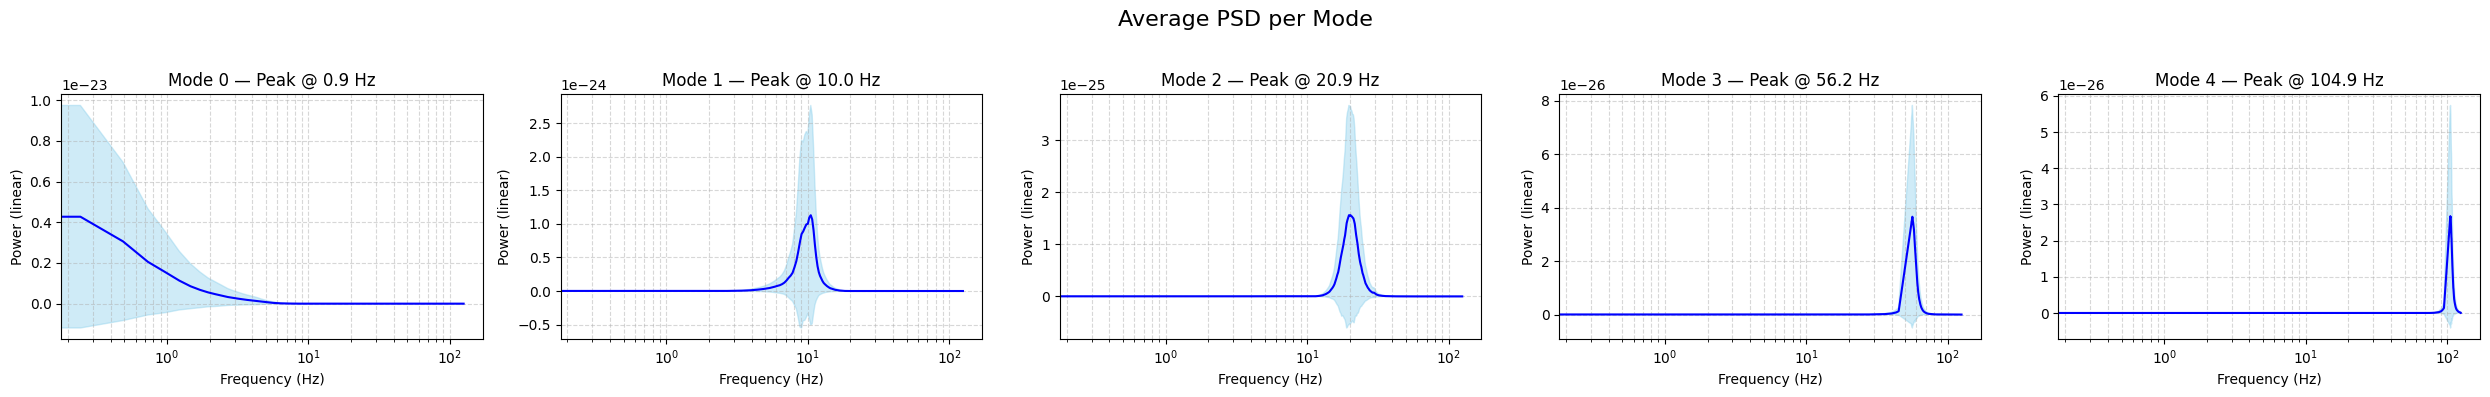

In [9]:
mvmd_plot_mean_mode_psds(
    modes=u,
    sfreq=fs,
    omega=omega,
    standardize=False,
    notch=True,
    scale='linear',         # or 'db'
    layout='horizental',      # or 'horizontal'
    suptitle="Average PSD per Mode"
)


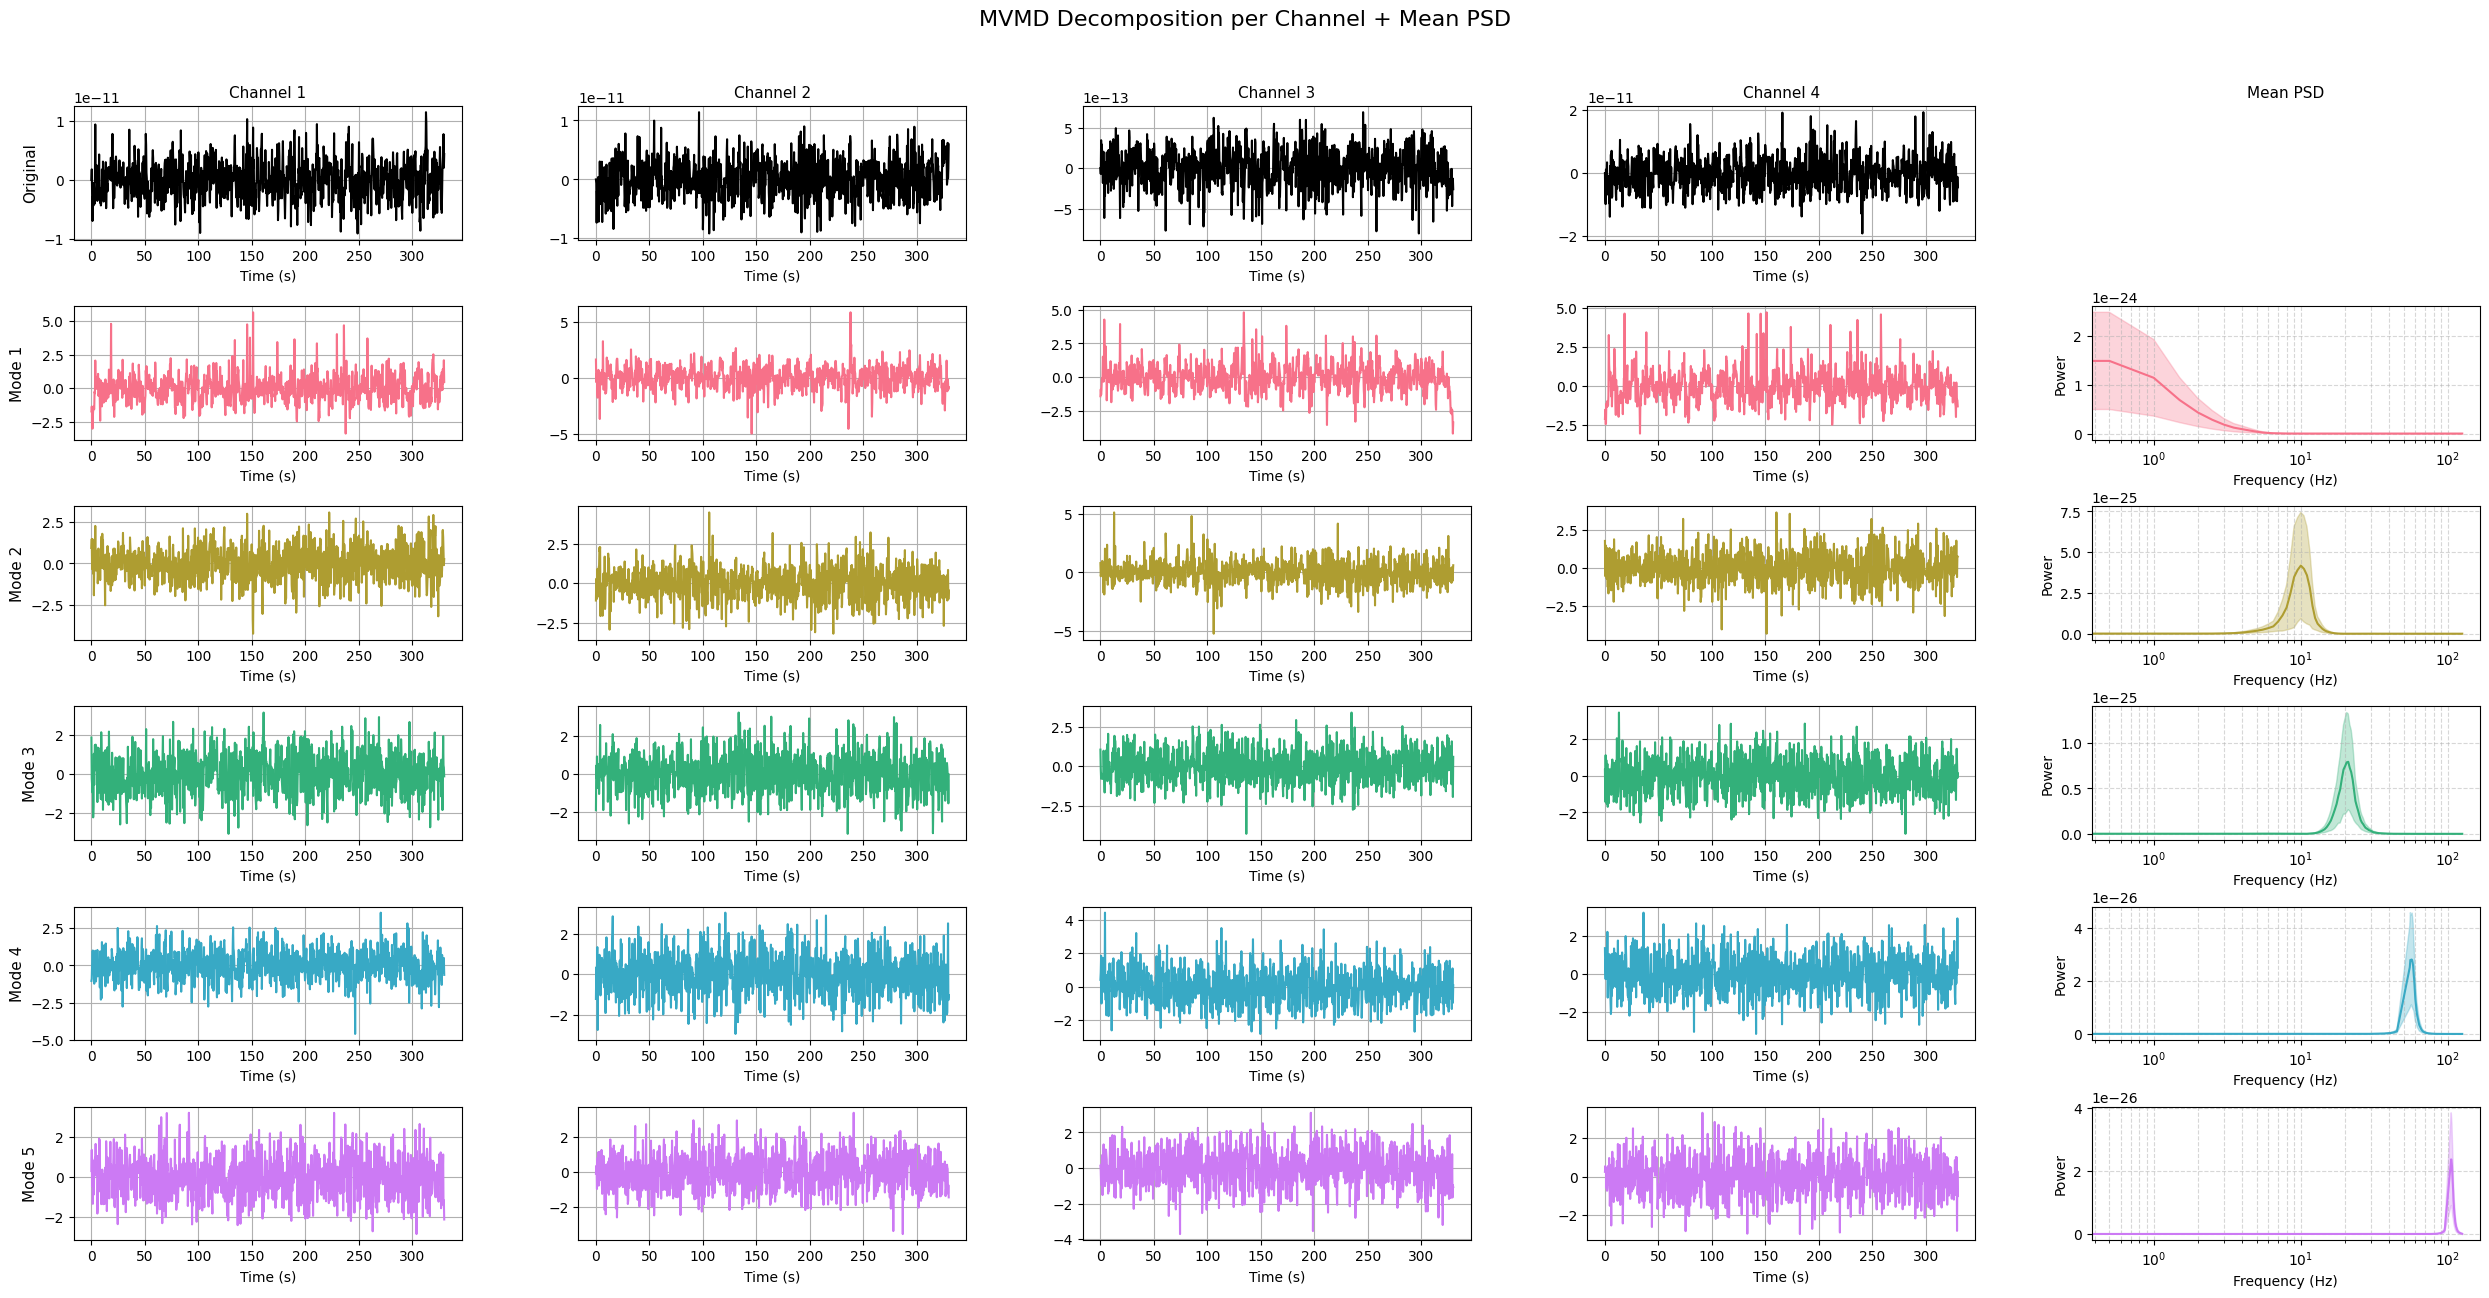

In [10]:
plot_mvmd_grid(
    original=data,
    modes=u,
    omega=omega,
    fs=250,  # or your actual sampling rate
    selected_channels=[1,2,3,4],  # or any list of channel names
    max_points=1000,
    duration=330,  # or None to plot all
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=0,
    log_psd=False,   # or False for linear scale
    log_freq=True   # or False if you want linear freq
)


In [11]:
def compute_mode_corr_matrix_across_channels(u):
    """
    Compute the average correlation matrix between modes across all channels.

    Parameters:
    - u: ndarray of shape (n_modes, n_samples, n_channels)

    Returns:
    - corr_matrix: average correlation matrix of shape (n_modes, n_modes)
    """
    n_modes, n_samples, n_channels = u.shape
    corr_matrices = []

    for ch in range(n_channels):
        data = u[:, :, ch]  # shape: (n_modes, n_samples)
        corr = np.corrcoef(data)
        corr_matrices.append(corr)

    # Average across channels
    corr_matrix = np.mean(corr_matrices, axis=0)
    return corr_matrix


def plot_mode_corr_matrix(
    corr_matrix,
    title="Average Mode Correlation Across Channels",
    cmap="coolwarm",
    figsize=(7, 6),
    mode_names=None,
    fontsize=12,
):
    """
    Plot a clean Seaborn heatmap of the mode correlation matrix.

    Parameters:
    - corr_matrix: square (n_modes x n_modes) matrix
    - title: title of the plot
    - cmap: color palette
    - figsize: figure size
    - mode_names: optional list of labels (e.g., ["Delta", "Theta", ...])
    - fontsize: font size for labels and annotations
    """
    n_modes = corr_matrix.shape[0]
    if mode_names is None:
        mode_names = [f"Mode {i+1}" for i in range(n_modes)]

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        square=True,
        xticklabels=mode_names,
        yticklabels=mode_names,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={"label": "Correlation"},
        vmin=0, vmax=1
    )

    ax.set_title(title, fontsize=fontsize + 2, weight='bold', pad=20)
    ax.set_xlabel("Mode Indexes", fontsize=fontsize)
    ax.set_ylabel("Mode Indexes", fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    plt.tight_layout()
    plt.show()





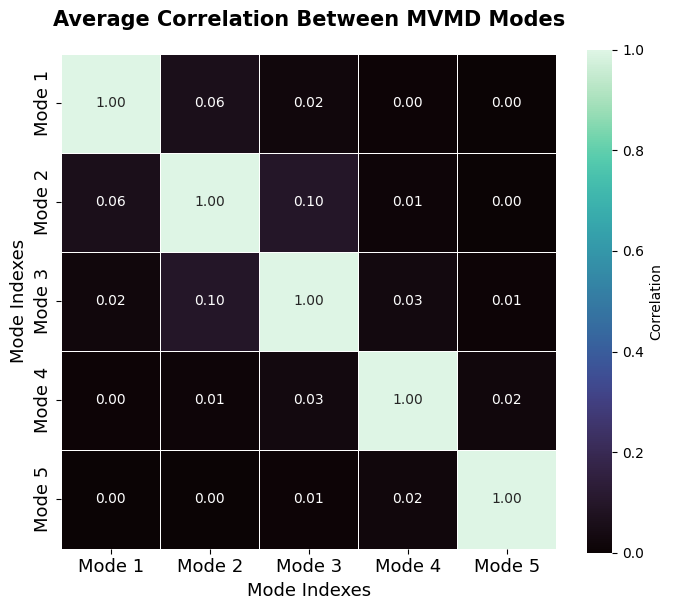

In [12]:
corr_matrix = compute_mode_corr_matrix_across_channels(u)

plot_mode_corr_matrix(
    corr_matrix,
    title="Average Correlation Between MVMD Modes",
    cmap="mako",  # Try "viridis", "mako", or "plasma" too
    mode_names=[f"Mode {i+1}" for i in range(u.shape[0])],
    fontsize=13
)


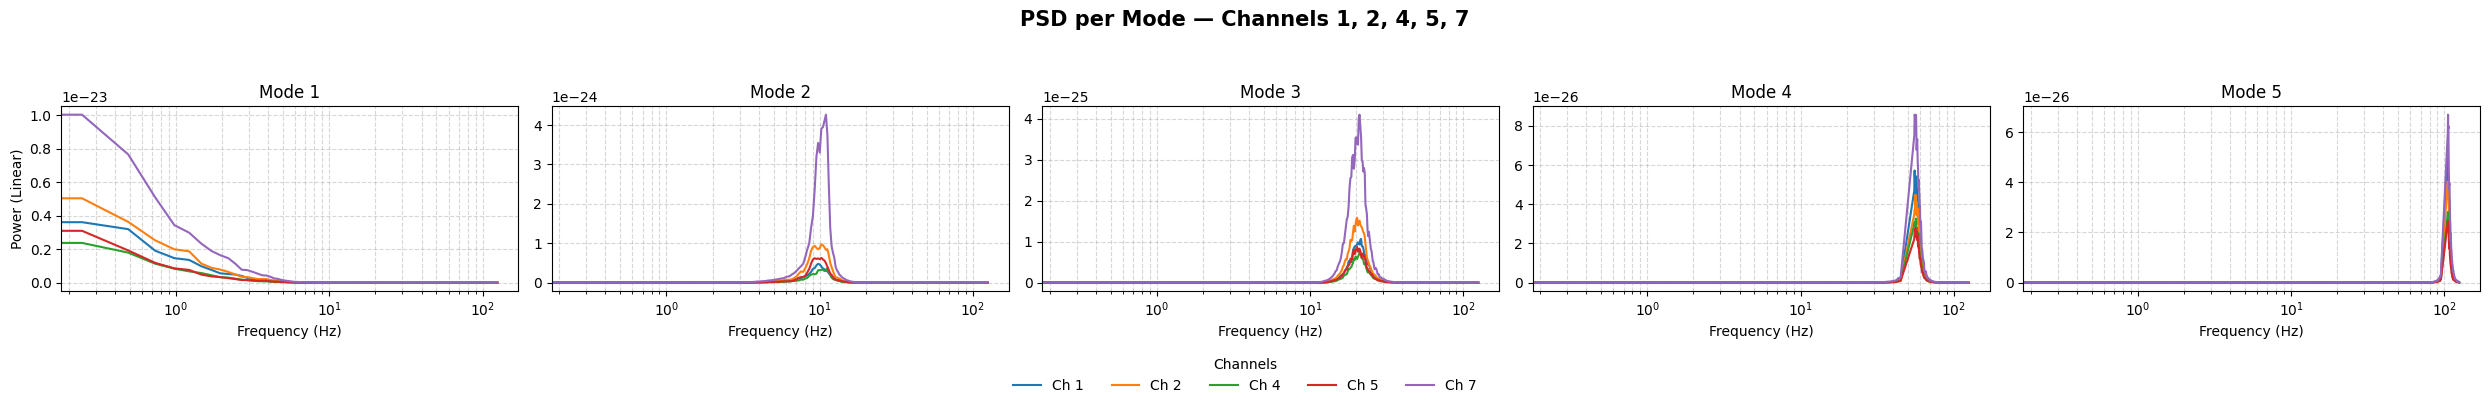

In [13]:

plot_mode_psds_multi_channel_modes_first(
    modes=u,
    sfreq=250,
    channel_indices=[1, 2,4,5,7],
    db_scale=False,
    standardize_psd=False,
    notch=True,
    log_scale=True,
    eps=0
)


## 3. Enveloppes extraction

In [14]:
omega.real

array([[  0.8732198,   9.975346 ,  20.900143 ,  56.230385 , 104.93458  ]],
      dtype=float32)

In [15]:
omega

array([[  0.8732198+0.j,   9.975346 +0.j,  20.900143 +0.j,
         56.230385 +0.j, 104.93458  +0.j]], dtype=complex64)

In [ ]:
# u shape: (n_modes, n_samples, n_channels)
# omega: torch tensor or np.ndarray already in Hz
extract_mvmd_envelopes(
    u=u,  # your MVMD output (n_modes, n_samples, n_channels)
    omega=omega,  # already multiplied by sfreq
    save_dir="../results/real/MVMD/envelopes",  # wherever you want
    sfreq=250
)


In [19]:
def load_all_envelopes(envelopes_dir, n_channels=306):
    """
    Load all envelope .npy files and stack into a single array:
    shape = (n_modes, n_samples, n_channels)
    """
    all_env = []
    for ch in range(n_channels):
        path = os.path.join(envelopes_dir, f"meg_channel_{ch}_envelopes.npy")
        if not os.path.exists(path):
            print(f"⚠️ Missing file: {path}")
            continue
        env = np.load(path)  # shape: (n_modes, n_samples)
        all_env.append(env[..., np.newaxis])  # shape: (n_modes, n_samples, 1)

    # Stack along last axis (channels)
    stacked_env = np.concatenate(all_env, axis=-1)
    return stacked_env


def compute_envelope_correlation_per_mode(envelopes):
    """
    Compute correlation matrices for each mode across all channels.

    Parameters
    ----------
    envelopes : np.ndarray
        Array of shape (n_modes, n_timepoints, n_channels)

    Returns
    -------
    dict
        Dictionary with keys = mode index, values = (306 x 306) correlation matrix
    """
    n_modes, n_timepoints, n_channels = envelopes.shape
    corr_dict = {}

    for m in range(n_modes):
        # Transpose to shape (n_channels, n_timepoints)
        data = envelopes[m].T
        corr = np.corrcoef(data)
        corr_dict[m] = corr

    return corr_dict


In [20]:
envelopes = load_all_envelopes("../results/real/MVMD/envelopes")

In [21]:
# envelopes shape should be (n_modes, n_timepoints, n_channels)
correlation_matrices = compute_envelope_correlation_per_mode(envelopes)

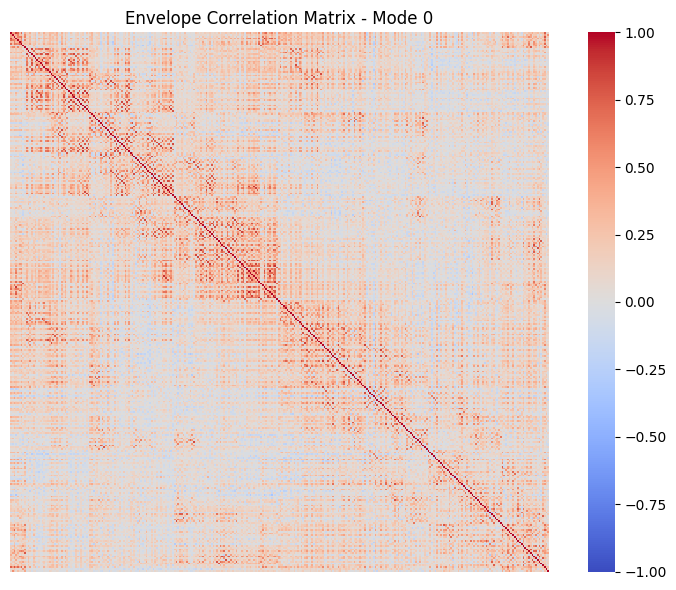

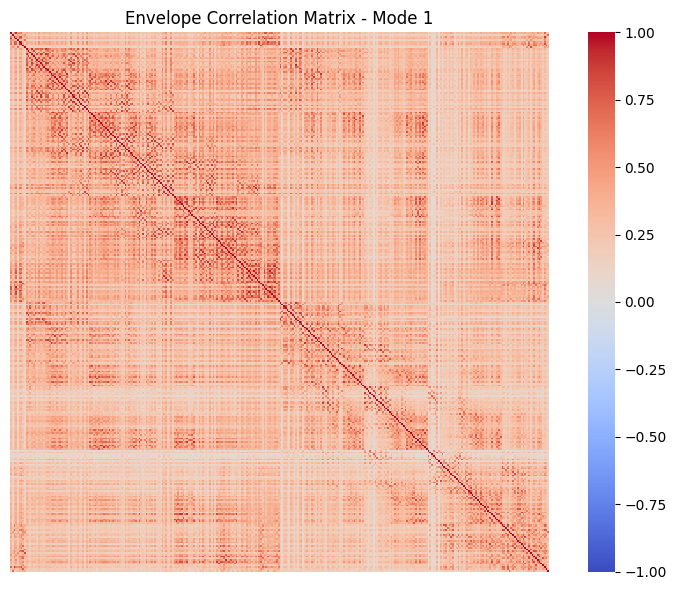

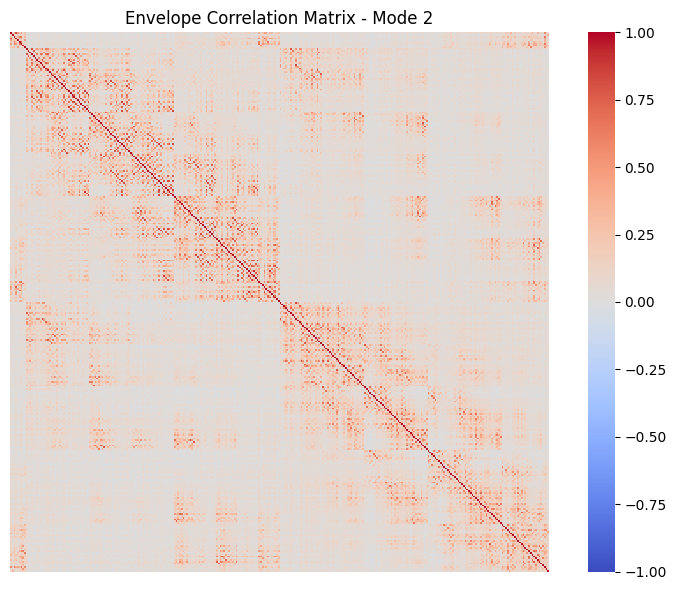

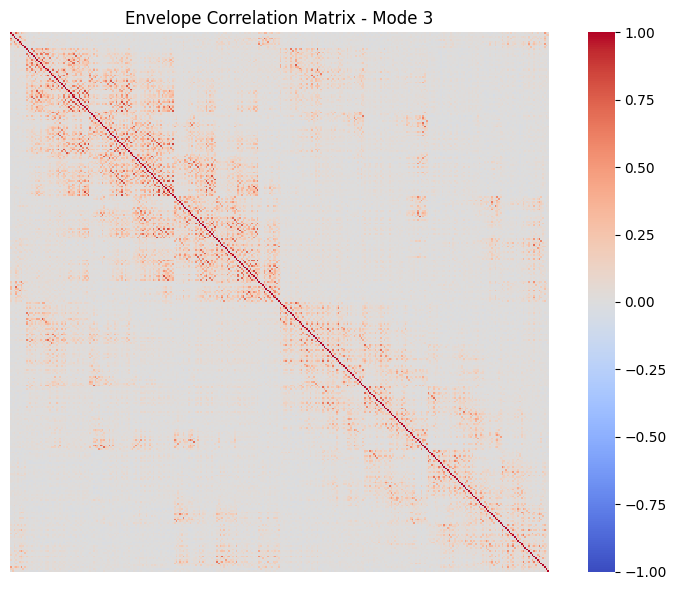

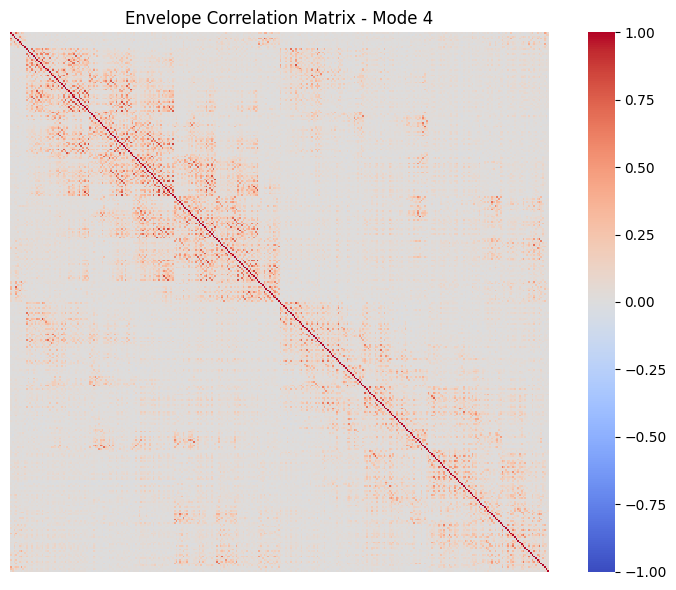

In [22]:
# Display each mode's correlation matrix
for mode_idx, corr in correlation_matrices.items():
    mvmd_plot_correlation_matrix_enveloppe(corr, mode_idx)

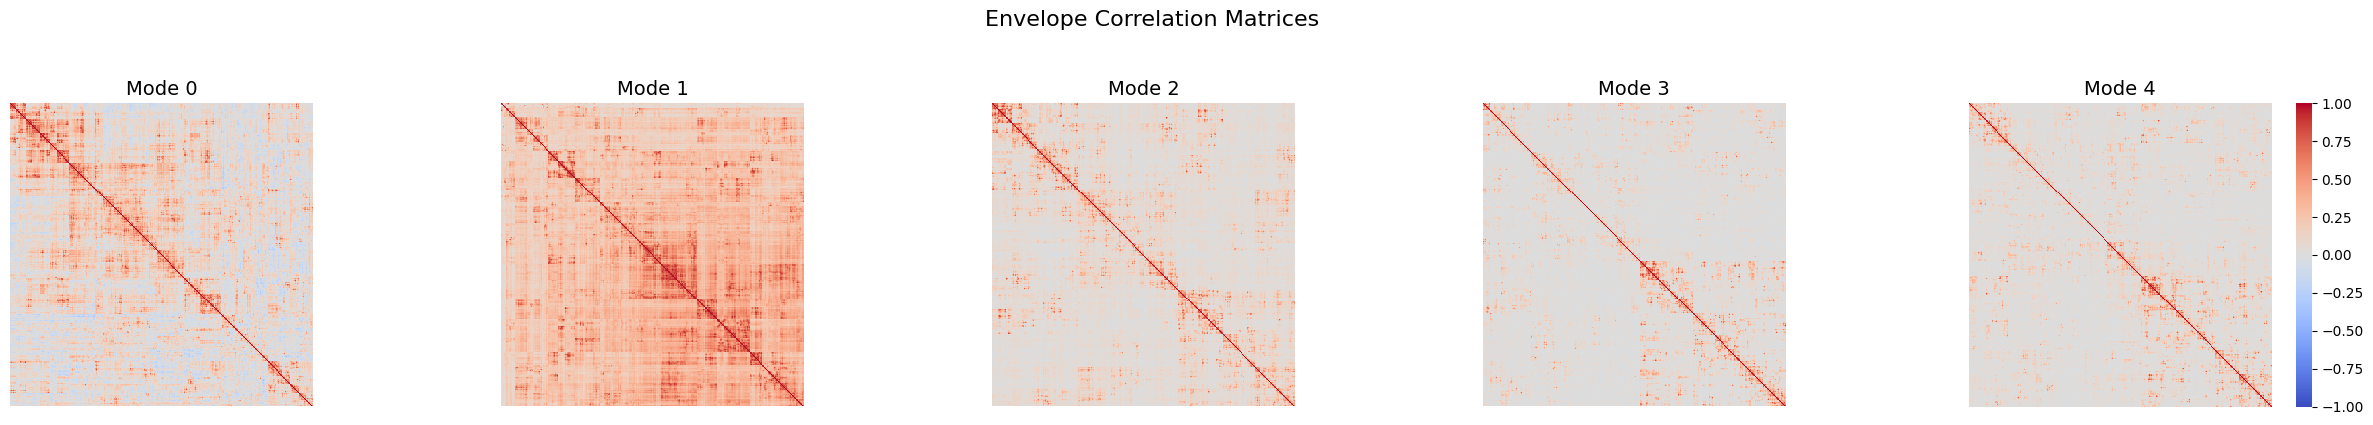

In [23]:
# Reordered the correlation matrices based on Hierarchical Clustering

# Plot reordered matrices
mvmd_plot_correlation_matrix_enveloppe_reordered(correlation_matrices, mode_indices=[0, 1, 2, 3, 4])


### The dataframe modes_df has been built but if you are running your own decomposition and you want to built it again you can run this step


In [ ]:
# def build_modes_df_mvmd(u_path, envelope_dir, raw_path=None):
#     """
#     Build modes_df for MVMD from decomposed signals and saved envelopes.

#     Parameters:
#     - u_path: path to .npz file containing MVMD result (`u`)
#     - envelope_dir: path to folder containing meg_channel_{i}_envelopes.npy
#     - raw_path: optional path to raw MEG file (to extract channel names)

#     Returns:
#     - modes_df: DataFrame with columns: channel, channel_name, mode_idx, signal, envelope
#     """
#     # === Load MVMD results ===
#     data = np.load(u_path)
#     u = data['u']  # Shape: (n_modes, n_samples, n_channels)
#     n_modes, n_samples, n_channels = u.shape

#     # === Load channel names ===
#     channel_names = [f"MEG {i:03d}" for i in range(n_channels)]
#     if raw_path is not None:
#         raw = mne.io.read_raw_fif(raw_path, preload=False)
#         channel_names = raw.info['ch_names']

#     # === Build DataFrame ===
#     rows = []
#     for ch in range(n_channels):
#         envelope_path = os.path.join(envelope_dir, f"meg_channel_{ch}_envelopes.npy")
#         if not os.path.exists(envelope_path):
#             print(f"⚠️ Missing envelope for channel {ch}. Skipping.")
#             continue
#         envelopes = np.load(envelope_path)  # Shape: (n_modes, n_samples)

#         for m in range(n_modes):
#             signal = u[m, :, ch]
#             envelope = envelopes[m]
#             rows.append({
#                 "channel": ch,
#                 "channel_name": channel_names[ch],
#                 "mode_idx": m,
#                 "signal": signal,
#                 "envelope": envelope
#             })

#     modes_df = pd.DataFrame(rows)
#     return modes_df


# modes_df = build_modes_df_mvmd(
#     u_path="../results/real/MVMD/modes/mvmd_modes_sub-01.npz",
#     envelope_dir="../results/real/MVMD/envelopes",
#     raw_path="../data/sub-01_ses-01_task-rest_proc-filt_raw.fif"  # optional
# )


# # Save the modes_df to a pickle file
# modes_df.to_pickle("../results/real/MVMD/modes_df.pkl")
# print("✅ modes_df saved to ../results/real/MVMD/modes_df.pkl")


Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.


In [ ]:
modes_df = pd.read_pickle("../results/real/MVMD/modes_df.pkl")

## 3. MFA

In [29]:
scaling_ranges = [(6, 12)]
q_vals = np.arange(-3, 6)
summary_records = []
methods = ["VMD"]

In [26]:

# A quelle fréquence correspond le j 
# integrate 1
# bias correction -> 0.3.2 branch github
# PCA/ICA : modele linéaire, suppose que le mélange est constant 
# Amplitude/Phase modes à revoir
# Question à poser à Merlin : Sur le pic fréquence VS la décorrlation (phrase)

# from pymultifracs.utils import scale2freq
# scale2freq(8, 250, 'db3')
# ?scale2freq


📊 Processing mode_idx = 0


<Figure size 800x400 with 0 Axes>

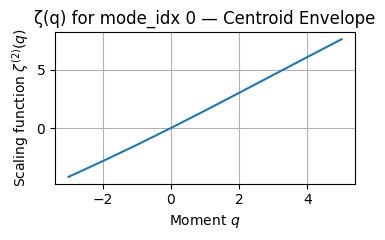

<Figure size 800x400 with 0 Axes>

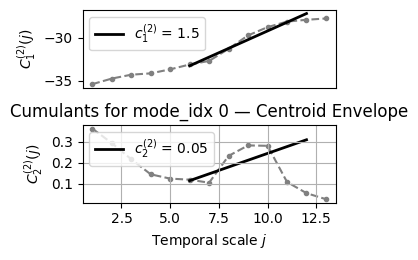

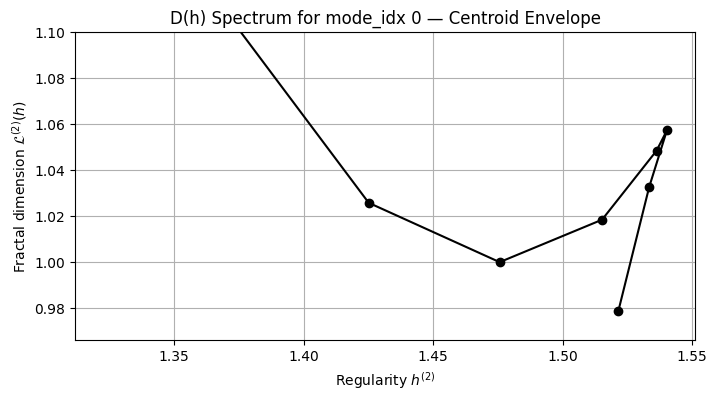


📊 Processing mode_idx = 1


<Figure size 800x400 with 0 Axes>

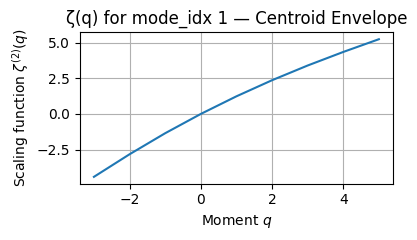

<Figure size 800x400 with 0 Axes>

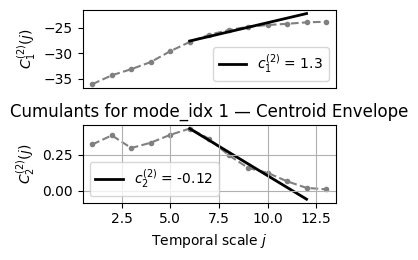

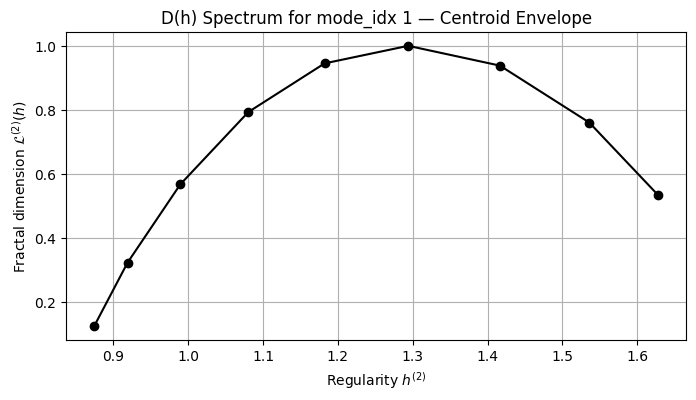


📊 Processing mode_idx = 2


<Figure size 800x400 with 0 Axes>

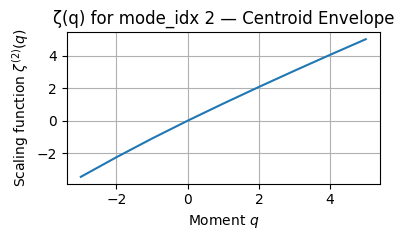

<Figure size 800x400 with 0 Axes>

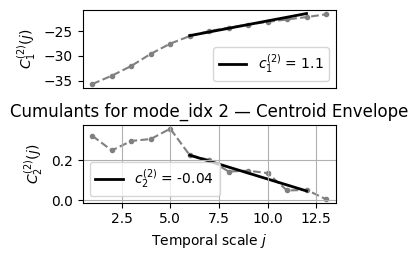

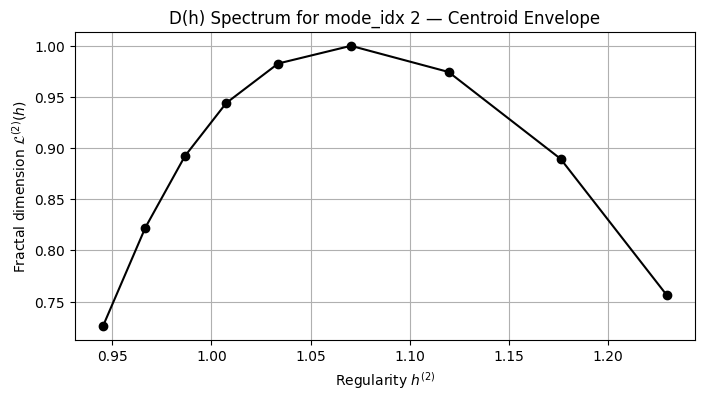


📊 Processing mode_idx = 3


<Figure size 800x400 with 0 Axes>

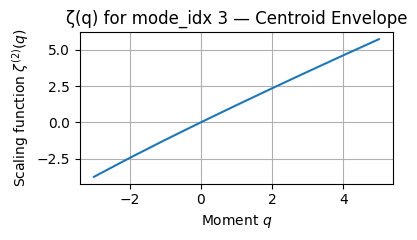

<Figure size 800x400 with 0 Axes>

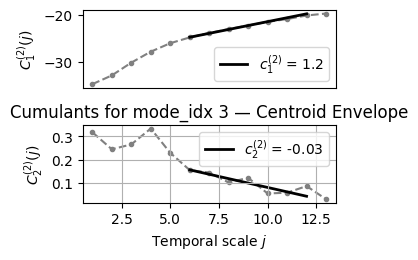

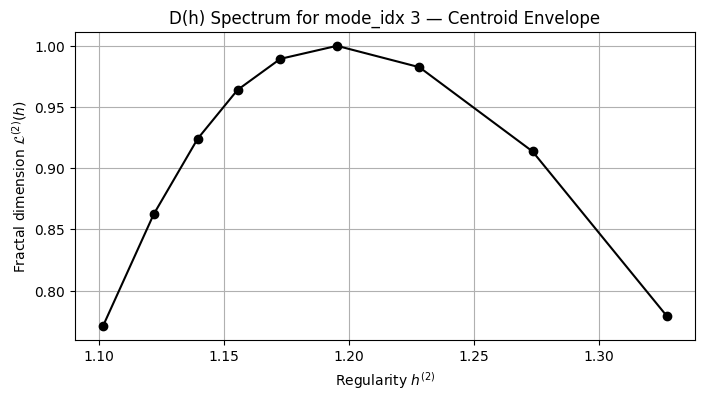


📊 Processing mode_idx = 4


<Figure size 800x400 with 0 Axes>

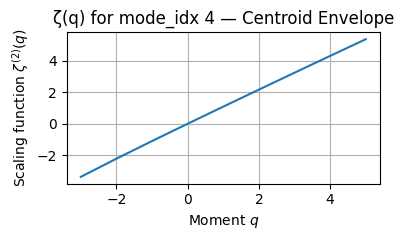

<Figure size 800x400 with 0 Axes>

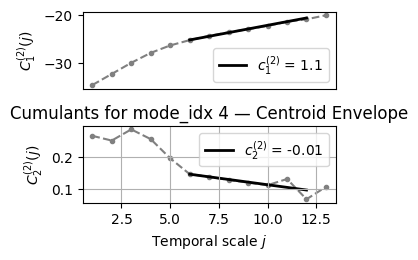

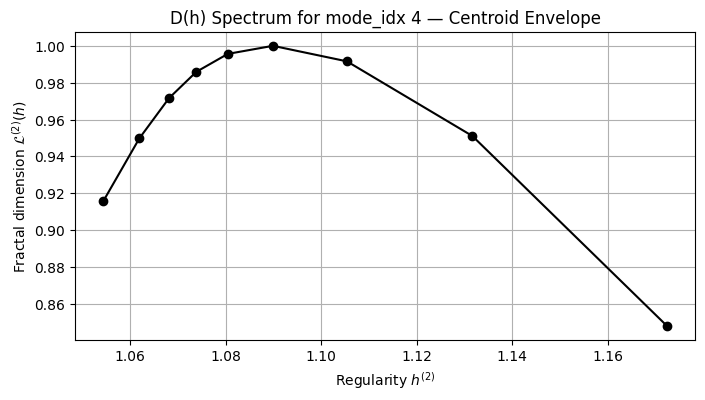

In [30]:
summary_df = mfa_on_envelope_centroids(
    modes_df=modes_df,
    scaling_ranges=scaling_ranges,
    q_vals=q_vals,
    output_base="../results/real/MVMD/",
    group_by="mode_idx"
)
